In [1]:
import os
import re
import collections
import typing as tp
import itertools
import statistics
import operator
import textwrap

import pymorphy3
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
MORPH = pymorphy3.MorphAnalyzer()

In [3]:
POEMS_PATH = "poems"

In [4]:
metrics_translator_mapping = {
    "stanzas": "Количество строф",
    "lines": "Количество строк",
    "sentences": "Количество предложений",
    "pos": "Количество частей речи",
    "average_lines_per_stanza": "Среднее количество строк в строфе",
    "average_words_per_line": "Среднее количество слов в строке",
    "average_words_per_sentence": "Среднее количество слов в предложении",
    "average_pos": "Среднее количество частей речи в предложении",
    "average_pos_per_line": "Среднее количество частей речи в строке",
    "average_pos_per_sentence": "Среднее количество частей речи в предложении",
}

pos_translator_mapping = {
    "CONJ": "Союз",
    "NPRO": "Местоимение",
    "VERB": "Глагол",
    "PREP": "Предлог",
    "NOUN": "Существительное",
    "ADVB": "Наречие",
    "ADJF": "Прилагательное",
    "PRCL": "Частица",
    "PRTF": "Причастие",
    "INFN": "Инфинитив",
    "NUMR": "Числительное",
    "GRND": "Деепричастие",
    "INTJ": "Междометие",
    "COMP": "Сравнительная частица",
    "ADJS": "Краткое прилагательное",
    "PRED": "Предикатив",
    "PRTS": "Краткое причастие",
}

In [5]:
SENTENCE_SPLIT_REGEX = re.compile(r'[.!?]+')

In [6]:
def read_text(path: str) -> str:
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

In [7]:
def normalize_text(text: str) -> str:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    return "\n".join(map(str.strip, text.split('\n')))


In [8]:
def safe_mean(values: tp.Iterable[float]) -> float:
    values_list = list(values)
    return statistics.mean(values_list) if values_list else 0.0

In [9]:
def get_stanzas(text: str) -> list[str]:
    return [s for stanza in text.strip().split('\n\n') if (s := stanza.strip())]

In [10]:
def get_lines(text: str) -> list[str]:
    return [l for line in text.splitlines() if (l := line.strip())]

In [11]:
def get_sentences(text: str) -> list[str]:
    return [s for sentence in SENTENCE_SPLIT_REGEX.split(text) if (s := sentence.strip())]

In [12]:
def compute_stanzas(text: str) -> int:
    return len(get_stanzas(text))

In [13]:
def compute_lines(text: str) -> int:
    return len(get_lines(text))

In [14]:
def compute_sentences(text: str) -> int:
    return len(get_sentences(text))

In [15]:
def compute_pos(text: str) -> dict[str, int]:
    tokens = text.split()
    pos_counter = collections.Counter()
    for token in tokens:
        parsed = MORPH.parse(token)[0]
        pos = parsed.tag.POS
        if pos:
            pos_counter[pos] += 1
    return dict(pos_counter)

In [16]:
def compute_average_lines_per_stanza(text: str) -> float:
    total_lines = compute_lines(text)
    total_stanzas = compute_stanzas(text)
    return total_lines / total_stanzas if total_stanzas else 0.0

In [17]:
def compute_average_words_per_line(text: str) -> float:
    lines = get_lines(text)
    if not lines:
        return 0.0
    total_words = sum(len(line.split()) for line in lines)
    return total_words / len(lines)

In [18]:
def compute_average_words_per_sentence(text: str) -> float:
    sentences = get_sentences(text)
    if not sentences:
        return 0.0
    total_words = sum(len(sentence.split()) for sentence in sentences)
    return total_words / len(sentences)

In [19]:
def compute_average_pos(text: str) -> dict[str, float]:
    pos_counts = compute_pos(text)
    tokens = text.split()
    total_tokens = len(tokens)
    if total_tokens == 0:
        return {}
    return {pos: count / total_tokens for pos, count in pos_counts.items()}

In [20]:
def compute_average_pos_per_line(text: str) -> dict[str, float]:
    lines = get_lines(text)
    if not lines:
        return {}
    total_counter = collections.Counter()
    for line in lines:
        total_counter.update(compute_pos(line))
    return {pos: count / len(lines) for pos, count in total_counter.items()}

In [21]:
def compute_average_pos_per_sentence(text: str) -> dict[str, float]:
    sentences = get_sentences(text)
    if not sentences:
        return {}
    total_counter = collections.Counter()
    for sentence in sentences:
        total_counter.update(compute_pos(sentence))
    return {pos: count / len(sentences) for pos, count in total_counter.items()}

In [22]:
def aggregate_mean_pos(poses: tp.Iterable[tp.Mapping[str, float]]) -> dict[str, float]:
    poses_list = list(poses)

    if not poses_list:
        return {}

    keys = set(itertools.chain.from_iterable(pos.keys() for pos in poses_list))

    return {
        key: safe_mean(pos[key] for pos in poses_list if key in pos)
        for key in keys
    }


In [23]:
def string_metric(
    metric: tuple[str, int | float | tp.Mapping[str, float]],
    *,
    indent: int = 1,
) -> str:
    name, value = metric

    if isinstance(value, (int, float)):
        return f"{metrics_translator_mapping[name]}: {value:.2f}"

    string_poses = '\n'.join(
        f"{pos_translator_mapping[pos]}: {count:.2f}"
        for pos, count in value.items()
    )

    return f"{metrics_translator_mapping[name]}:\n{textwrap.indent(string_poses, '\t' * indent)}"

In [24]:
def plot_structural_metrics(authors: tp.Sequence[tp.Mapping[str, tp.Any]]) -> None:
    structural_metrics = [
        "stanzas",
        "lines",
        "sentences",
        "average_lines_per_stanza",
        "average_words_per_line",
        "average_words_per_sentence",
    ]

    structural_data = []
    for author in authors:
        for metric in structural_metrics:
            structural_data.append(
                {
                    "Автор": author["name"],
                    "Метрика": metrics_translator_mapping[metric],
                    "Значение": author["metrics"][metric]
                }
            )

    df_structural = pd.DataFrame(structural_data)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_structural, x="Автор", y="Значение", hue="Метрика")
    plt.title("Структурные метрики по авторам")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [25]:
def plot_pos_metrics(authors: tp.Sequence[tp.Mapping[str, tp.Any]]) -> None:
    pos_data = []

    for author in authors:
        pos_dict = author["metrics"]["pos"]
        for pos, value in pos_dict.items():
            pos_data.append(
                {
                    "Автор": author["name"],
                    "Часть речи": pos_translator_mapping.get(pos, pos),
                    "Количество": value
                }
            )

    df_pos = pd.DataFrame(pos_data)

    plt.figure(figsize=(14, 8))
    sns.barplot(data=df_pos, x="Часть речи", y="Количество", hue="Автор")
    plt.title("Сравнительное распределение частей речи по авторам")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [26]:
poems = [
    {
        "author": author,
        "title": title.removesuffix(".txt"),
        "content": normalize_text(read_text(os.path.join(POEMS_PATH, author, title))),
    }
    for author in os.listdir(POEMS_PATH)
    for title in os.listdir(os.path.join(POEMS_PATH, author))
]

In [27]:
authors = [
    {
        "name": author,
        "poems": list(poems),
    }
    for author, poems in itertools.groupby(poems, key=lambda p: p["author"])
]

In [28]:
poems.sort(key=operator.itemgetter("author", "title"))

In [29]:
authors.sort(key=operator.itemgetter("name"))

In [30]:
for poem in poems:
    content = poem["content"]
    poem["metrics"] = {
        "stanzas": compute_stanzas(content),
        "lines": compute_lines(content),
        "sentences": compute_sentences(content),
        "average_lines_per_stanza": compute_average_lines_per_stanza(content),
        "average_words_per_line": compute_average_words_per_line(content),
        "average_words_per_sentence": compute_average_words_per_sentence(content),
        "pos": compute_pos(content),
        "average_pos": compute_average_pos(content),
        "average_pos_per_line": compute_average_pos_per_line(content),
        "average_pos_per_sentence": compute_average_pos_per_sentence(content),
    }

In [31]:
for author in authors:
    poems = author["poems"]
    poems_metrics = list(map(operator.itemgetter("metrics"), poems))

    author["metrics"] = {
        "stanzas": safe_mean(map(operator.itemgetter("stanzas"), poems_metrics)),
        "lines": safe_mean(map(operator.itemgetter("lines"), poems_metrics)),
        "sentences": safe_mean(map(operator.itemgetter("sentences"), poems_metrics)),
        "average_lines_per_stanza": safe_mean(map(operator.itemgetter("average_lines_per_stanza"), poems_metrics)),
        "average_words_per_line": safe_mean(map(operator.itemgetter("average_words_per_line"), poems_metrics)),
        "average_words_per_sentence": safe_mean(map(operator.itemgetter("average_words_per_sentence"), poems_metrics)),
        "pos": aggregate_mean_pos(map(operator.itemgetter("pos"), poems_metrics)),
        "average_pos": aggregate_mean_pos(map(operator.itemgetter("average_pos"), poems_metrics)),
        "average_pos_per_line": aggregate_mean_pos(map(operator.itemgetter("average_pos_per_line"), poems_metrics)),
        "average_pos_per_sentence": aggregate_mean_pos(map(operator.itemgetter("average_pos_per_sentence"), poems_metrics)),
    }

In [32]:
for author in authors:
    name = author["name"]
    metrics = '\n'.join(map(string_metric, author['metrics'].items()))

    print(
        name,
        textwrap.indent(metrics, '\t' * 1),
        sep="\n",
        end="\n\n",
    )

Александр Введенский
	Количество строф: 2.22
	Количество строк: 78.44
	Количество предложений: 17.33
	Среднее количество строк в строфе: 52.56
	Среднее количество слов в строке: 3.80
	Среднее количество слов в предложении: 68.71
	Количество частей речи:
		Глагол: 39.33
		Местоимение: 28.44
		Предикатив: 1.75
		Инфинитив: 4.11
		Деепричастие: 5.20
		Союз: 27.89
		Краткое прилагательное: 2.00
		Предлог: 26.00
		Наречие: 16.00
		Прилагательное: 20.00
		Причастие: 3.80
		Междометие: 2.00
		Сравнительная частица: 3.00
		Частица: 12.78
		Существительное: 66.89
		Числительное: 1.75
		Краткое причастие: 1.00
	Среднее количество частей речи в предложении:
		Глагол: 0.12
		Местоимение: 0.08
		Предикатив: 0.01
		Инфинитив: 0.01
		Деепричастие: 0.01
		Союз: 0.08
		Краткое прилагательное: 0.01
		Предлог: 0.08
		Наречие: 0.05
		Прилагательное: 0.06
		Причастие: 0.01
		Междометие: 0.00
		Сравнительная частица: 0.01
		Частица: 0.04
		Существительное: 0.19
		Числительное: 0.01
		Краткое причастие: 0.00

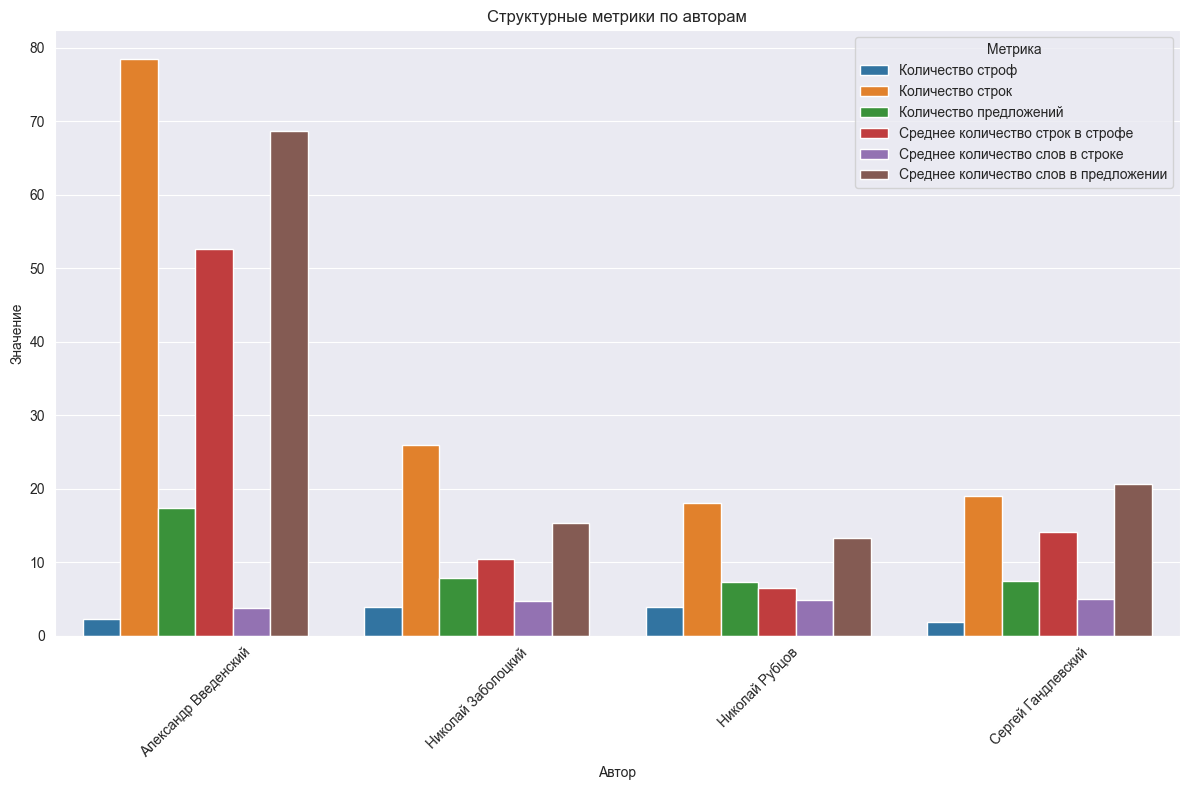

In [33]:
plot_structural_metrics(authors)

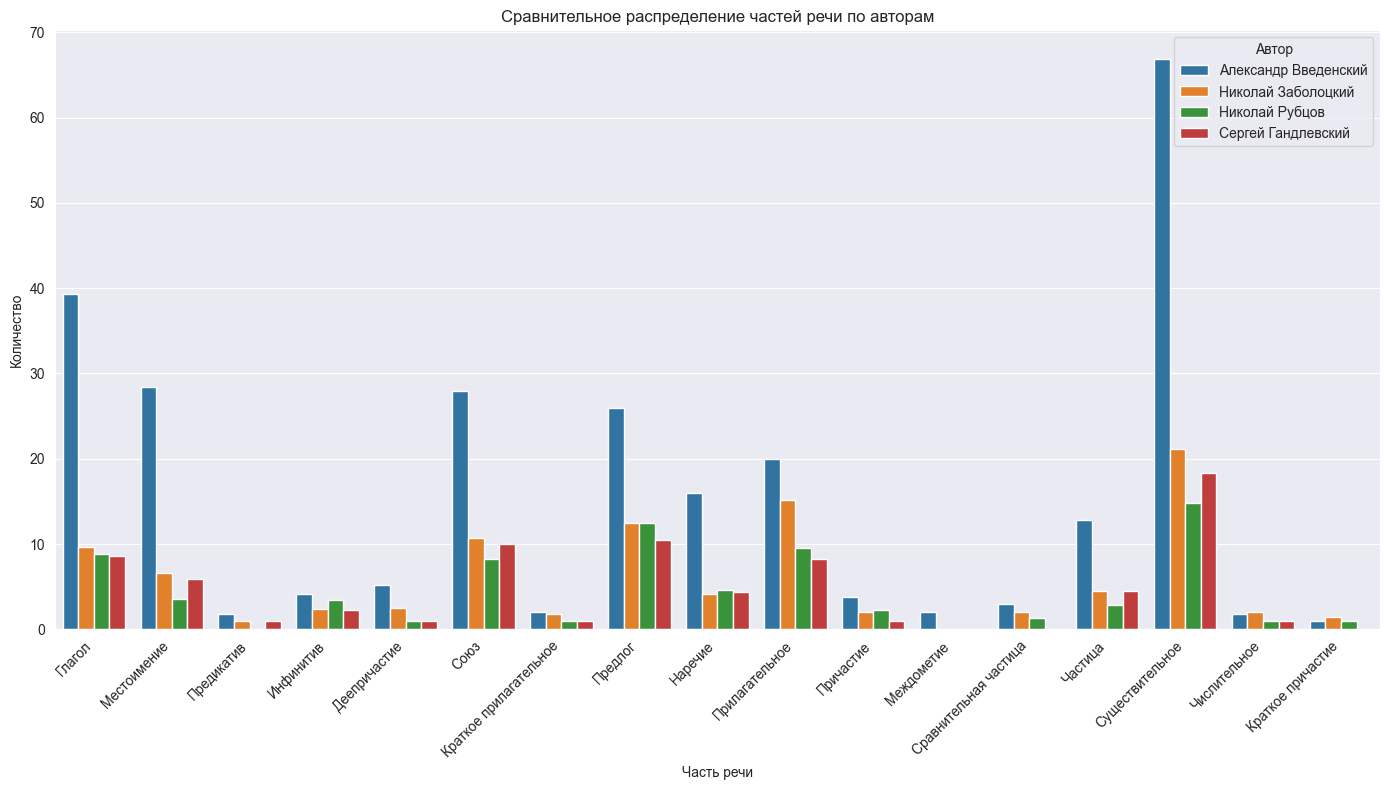

In [34]:
plot_pos_metrics(authors)